In [1]:
import xarray as xr
import numpy as np
import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap

## Monthly composite

In [2]:
data_arrays = []
month_str = "2024 Oct"

for day in range(1, 32):  # Days 1 to 31
    date_str = f"202410{day:02d}"  # Format the day with leading zero if needed
    # Open the DataArray for the current day
    file_path = f"composite/global/global_{date_str}.nc"
    data_array = xr.open_dataarray(file_path)
    
    # Set negative values to NaN (only keep positive values)
    data_array = data_array.where(data_array > 0)

    data_arrays.append(data_array)

# Stack the DataArrays along a new dimension, then take the mean across that dimension
mean_FLCI = xr.concat(data_arrays, dim="time").mean(dim="time")

Calculating the interquartile range (IQR) and standard deviation:

In [3]:
combined_data = xr.concat(data_arrays, dim="time")

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
q1 = combined_data.quantile(0.25, dim="time")
q3 = combined_data.quantile(0.75, dim="time")

# Calculate the IQR
IQR = q3 - q1

# Standard deviation
std_dev = combined_data.std(dim="time")

/home/jturner/miniconda3/envs/flc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [4]:
# Coefficient of Variation
cv = (std_dev / mean_FLCI) * 100

Adjusting the longitude values:

In [5]:
lons = mean_FLCI.longitude-180

Mapping the results:

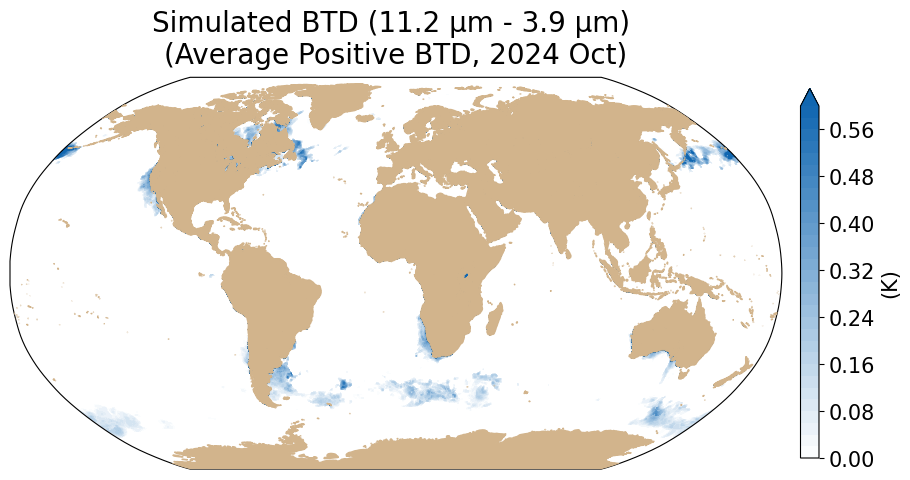

In [6]:
tool = "mean"  # "IQR, mean, std_dev, cv"

if tool == "mean":
    BTD = mean_FLCI
if tool == "IQR":
    BTD = IQR
if tool == "std_dev":
    BTD = std_dev
if tool == "cv":
    BTD = cv

projection = ccrs.Robinson(central_longitude=0)
fig, ax = plt.subplots(1, figsize=(12, 12), subplot_kw={'projection': projection})

colors = ['#FFFFFF', '#1167b1']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# --- Local max and min, taking into account the zeroes from the NAN region (land)
max_BTD = BTD.where(BTD > -20).max().item()
min_BTD = BTD.where(BTD > -20).min().item()

# --- Setting the colorbar levels
if tool == "mean":
    levels = np.linspace(0, 0.6, 31)
if tool == "IQR":
    levels = np.linspace(0, 0.9, 31)
if tool == "std_dev":
    levels = np.linspace(0, 0.9, 31)
if tool == "cv":
    levels = np.linspace(0, 100, 31)

# --- Plotting contourf
c = ax.contourf(
    mean_FLCI.longitude,
    mean_FLCI.latitude,
    BTD,
    cmap=cmap,
    extend='max',
    levels=levels,
    transform=ccrs.PlateCarree(),
)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

if tool == "cv":
    clb.set_label('(%)', fontsize=15)

if tool == "mean":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Average Positive BTD, " + month_str + ")", fontsize=20, pad=10)
if tool == "IQR":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive IQR BTD, " + month_str + ")", fontsize=20, pad=10)
if tool == "std_dev":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive standard deviation BTD, " + month_str + ")", fontsize=20, pad=10)
if tool == "cv":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive Coefficient of Variation, " + month_str + ")", fontsize=20, pad=10)

# --- Create a land mask without lakes
from cartopy.feature import NaturalEarthFeature

land_shp = shpreader.natural_earth(category='physical', name='land', resolution='50m')
lake_shp = shpreader.natural_earth(category='physical', name='lakes', resolution='50m')

# Read geometries for land and lakes
land_reader = shpreader.Reader(land_shp)
lake_reader = shpreader.Reader(lake_shp)
land_geoms = list(land_reader.geometries())
lake_geoms = list(lake_reader.geometries())

# Combine lakes into a single geometry
lakes_union = unary_union(lake_geoms)

# Subtract lakes from the land geometry
land_without_lakes = unary_union(land_geoms).difference(lakes_union)

# Add the resulting land mask
ax.add_geometries(
    [land_without_lakes],
    crs=ccrs.PlateCarree(),
    facecolor='tan',
    edgecolor='tan',
    zorder=100,
)

# --- Display figure
fig.savefig(
    "composite/monthly/flc_sim_" + month_str.replace(" ", "_") + "_" + tool,
    dpi=200,
    bbox_inches='tight',
)


## Seasonal composite

In [2]:
season_str = "2023-2024 OND"
season_months = ["202410", "202411", "202312"]

In [3]:
data_arrays = []
directory = "composite/global/"
file_patterns = [f"{directory}global_{prefix}*.nc" for prefix in season_months]

files = []
for pattern in file_patterns:
    files.extend(glob.glob(pattern))

for file_path in files:
    try:
        data_array = xr.open_dataarray(file_path)
        # Set negative values to NaN (only keep positive values)
        data_array = data_array.where(data_array > 0)
        data_arrays.append(data_array)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error opening file {file_path}: {e}")

# Stack the DataArrays along a new dimension, then take the mean across that dimension
if data_arrays:
    mean_FLCI = xr.concat(data_arrays, dim="time").mean(dim="time")
else:
    mean_FLCI = None
    print("No valid data arrays found.")

Seasonal composite is only set up for mean:

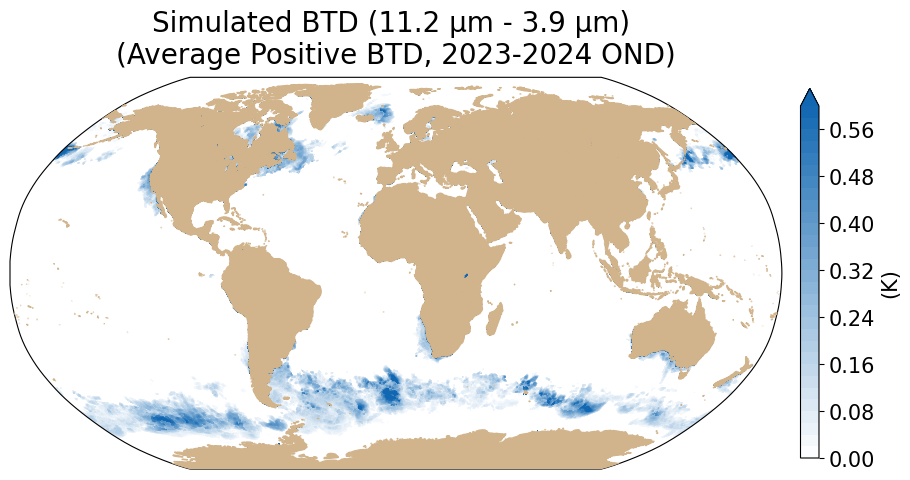

In [4]:
tool = "mean"  # "IQR, mean, std_dev, cv"

if tool == "mean":
    BTD = mean_FLCI
if tool == "IQR":
    BTD = IQR
if tool == "std_dev":
    BTD = std_dev
if tool == "cv":
    BTD = cv

projection = ccrs.Robinson(central_longitude=0)
fig, ax = plt.subplots(1, figsize=(12, 12), subplot_kw={'projection': projection})

colors = ['#FFFFFF', '#1167b1']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# --- Local max and min, taking into account the zeroes from the NAN region (land)
max_BTD = BTD.where(BTD > -20).max().item()
min_BTD = BTD.where(BTD > -20).min().item()

# --- Setting the colorbar levels
if tool == "mean":
    levels = np.linspace(0, 0.6, 31)
if tool == "IQR":
    levels = np.linspace(0, 0.9, 31)
if tool == "std_dev":
    levels = np.linspace(0, 0.9, 31)
if tool == "cv":
    levels = np.linspace(0, 100, 31)

# --- Plotting contourf
c = ax.contourf(
    mean_FLCI.longitude,
    mean_FLCI.latitude,
    BTD,
    cmap=cmap,
    extend='max',
    levels=levels,
    transform=ccrs.PlateCarree(),
)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

if tool == "cv":
    clb.set_label('(%)', fontsize=15)

if tool == "mean":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Average Positive BTD, " + season_str + ")", fontsize=20, pad=10)
if tool == "IQR":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive IQR BTD, " + season_str + ")", fontsize=20, pad=10)
if tool == "std_dev":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive standard deviation BTD, " + season_str + ")", fontsize=20, pad=10)
if tool == "cv":
    ax.set_title("Simulated BTD (11.2 μm - 3.9 μm) \n(Positive Coefficient of Variation, " + season_str + ")", fontsize=20, pad=10)

# --- Create a land mask without lakes
from cartopy.feature import NaturalEarthFeature

land_shp = shpreader.natural_earth(category='physical', name='land', resolution='50m')
lake_shp = shpreader.natural_earth(category='physical', name='lakes', resolution='50m')

# Read geometries for land and lakes
land_reader = shpreader.Reader(land_shp)
lake_reader = shpreader.Reader(lake_shp)
land_geoms = list(land_reader.geometries())
lake_geoms = list(lake_reader.geometries())

# Combine lakes into a single geometry
lakes_union = unary_union(lake_geoms)

# Subtract lakes from the land geometry
land_without_lakes = unary_union(land_geoms).difference(lakes_union)

# Add the resulting land mask
ax.add_geometries(
    [land_without_lakes],
    crs=ccrs.PlateCarree(),
    facecolor='tan',
    edgecolor='tan',
    zorder=100,
)

# --- Display figure
fig.savefig(
    "composite/seasonal/flc_sim_" + season_str.replace(" ", "_") + "_" + tool,
    dpi=200,
    bbox_inches='tight',
)